## Voice-Driven Disease Classification: A Deep Learning Approach

##### Team 34 : Jules Maglione, Paul Nadal

In [1]:
conda create -n py39 python=3.9

^C

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install -r requirements.txt

In [2]:
import os
import torch
import librosa
import warnings
import pandas as pd
from utils import *
import seaborn as sns
from math import ceil, sqrt
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from transformers import AutoFeatureExtractor, HubertForSequenceClassification, BertTokenizer, BertForSequenceClassification

%load_ext autoreload
%autoreload 2

warnings.filterwarnings("ignore")

In [3]:
DATA_DIR = './data/'
RESULTS_DIR = './results/'
RECORDINGS_DIR = DATA_DIR + 'recordings/'

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## 0. Dataset

> You can download the "Medical Speech, Transcription, and Intent" dataset from this [link](https://www.kaggle.com/datasets/paultimothymooney/medical-speech-transcription-and-intent/download?datasetVersionNumber=1). The dataset is approximately 6GB in size and includes thousands of audio utterances related to common medical symptoms such as "knee pain" or "headache." In total, the dataset comprises over 8 hours of aggregated audio content. Each utterance has been created by individual human contributors, who based their recordings on specific medical symptoms. This extensive collection of audio snippets is suitable for training conversational agents in the medical field.

#### 0.1 Load data

In [5]:
# Load the metadata from the CSV file

record_df = pd.read_csv(DATA_DIR + "overview-of-recordings.csv", sep=",")

print("Overview of recordings: ")
print("Number of recordings: ", len(record_df))
print("Number of features: ", len(record_df.columns))

Overview of recordings: 
Number of recordings:  6661
Number of features:  13


#### 0.2 Split data

In [6]:
# Add a column to categorize the recordings

train_files = set(os.listdir(os.path.join(RECORDINGS_DIR, "train")))
valid_files = set(os.listdir(os.path.join(RECORDINGS_DIR, "validate")))
test_files = set(os.listdir(os.path.join(RECORDINGS_DIR, "test")))

record_df["split"] = record_df.file_name.apply(lambda x: "train" if x in train_files else ("validate" if x in valid_files else "test"))

# Check the distribution of the recordings

print("Number of training samples: ", len(record_df[record_df.split == "train"]))
print("Number of validation samples: ", len(record_df[record_df.split == "validate"]))
print("Number of test samples: ", len(record_df[record_df.split == "test"]))

Number of training samples:  5895
Number of validation samples:  385
Number of test samples:  381


In [7]:
# Create a dictionary mapping each prompt to an integer
prompt_to_id = {prompt: i for i, prompt in enumerate(record_df.prompt.unique())}
id_to_prompt = {i: prompt for prompt, i in prompt_to_id.items()}
record_df["label"] = record_df.prompt.apply(lambda x: prompt_to_id[x])

print(id_to_prompt)

# Display the mapping
print("Prompt to ID mapping: ")
for prompt, id in prompt_to_id.items():
    print(prompt, ":", id)

Prompt to ID mapping: 
Emotional pain : 0
Hair falling out : 1
Heart hurts : 2
Infected wound : 3
Foot ache : 4
Shoulder pain : 5
Injury from sports : 6
Skin issue : 7
Stomach ache : 8
Knee pain : 9
Joint pain : 10
Hard to breath : 11
Head ache : 12
Body feels weak : 13
Feeling dizzy : 14
Back pain : 15
Open wound : 16
Internal pain : 17
Blurry vision : 18
Acne : 19
Muscle pain : 20
Neck pain : 21
Cough : 22
Ear ache : 23
Feeling cold : 24


In [8]:
# Save the updated CSV file 
record_df.to_csv(DATA_DIR + "overview-of-recordings-label.csv", index=False)

#### 0.3 Visualize data

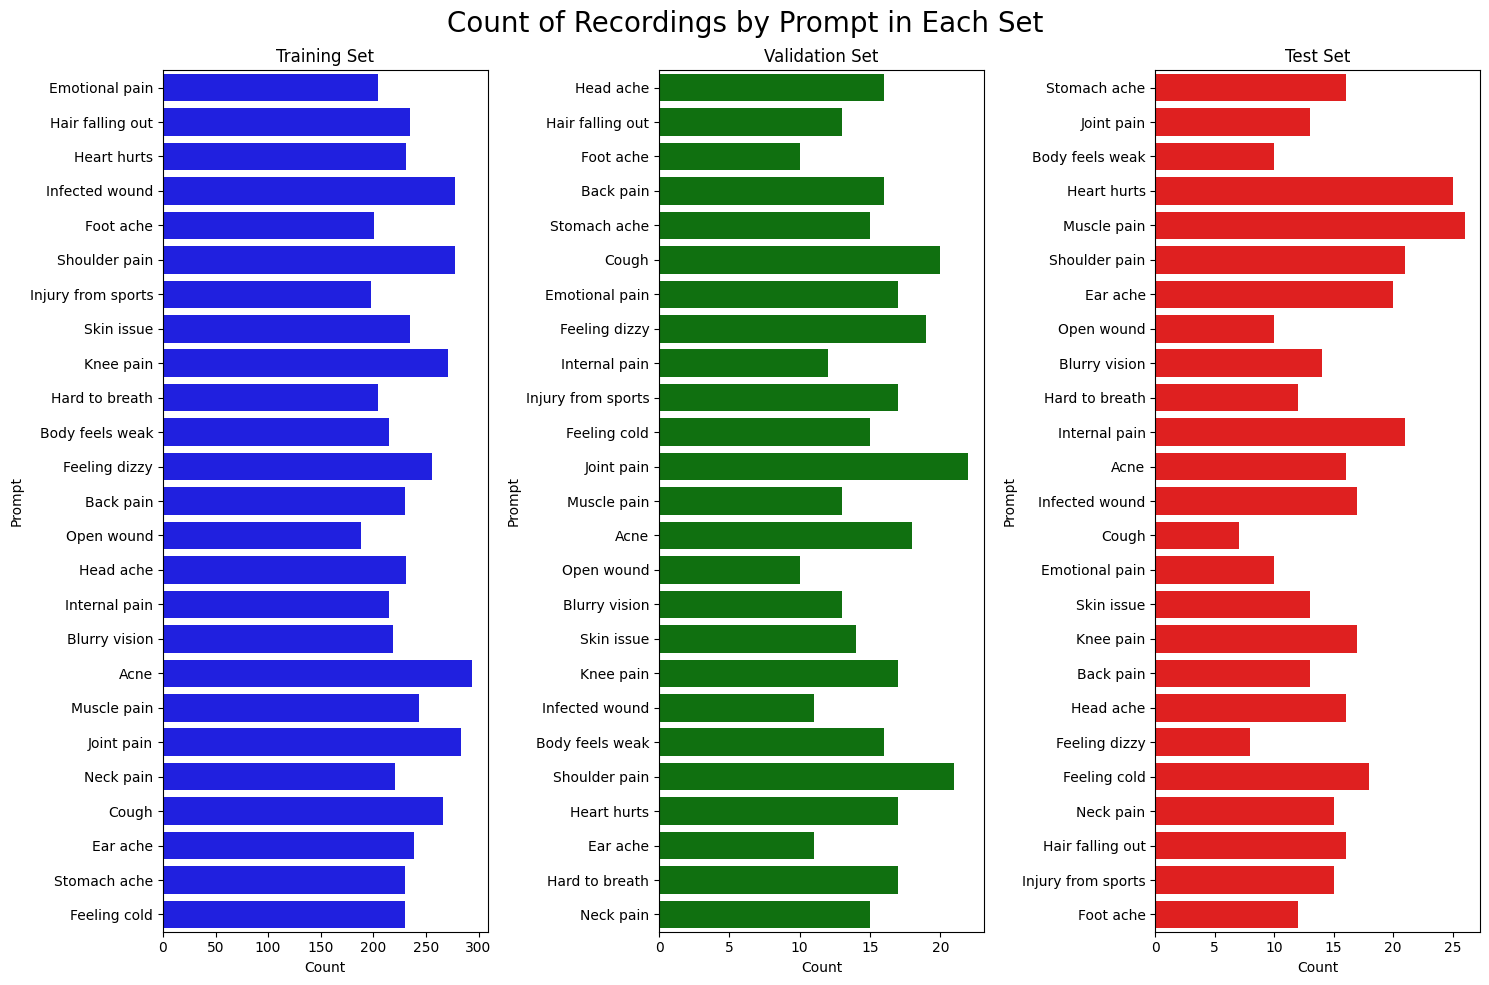

In [9]:
# Create train, validation, and test dataframes
train_df = record_df[record_df['split'] == 'train']
valid_df = record_df[record_df['split'] == 'validate']
test_df = record_df[record_df['split'] == 'test']

# Create a function to plot the count of each prompt
def create_count_plot(ax, df, title, color):
    sns.countplot(y='prompt', data=df, color=color, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Count')
    ax.set_ylabel('Prompt')

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 10))

# Combine the count plots on the same row
create_count_plot(axes[0], train_df, 'Training Set', 'blue')
create_count_plot(axes[1], valid_df, 'Validation Set', 'green')
create_count_plot(axes[2], test_df, 'Test Set', 'red')

# Adjust layout for better visualization
plt.suptitle('Count of Recordings by Prompt in Each Set', fontsize=20)
plt.tight_layout()
plt.show()

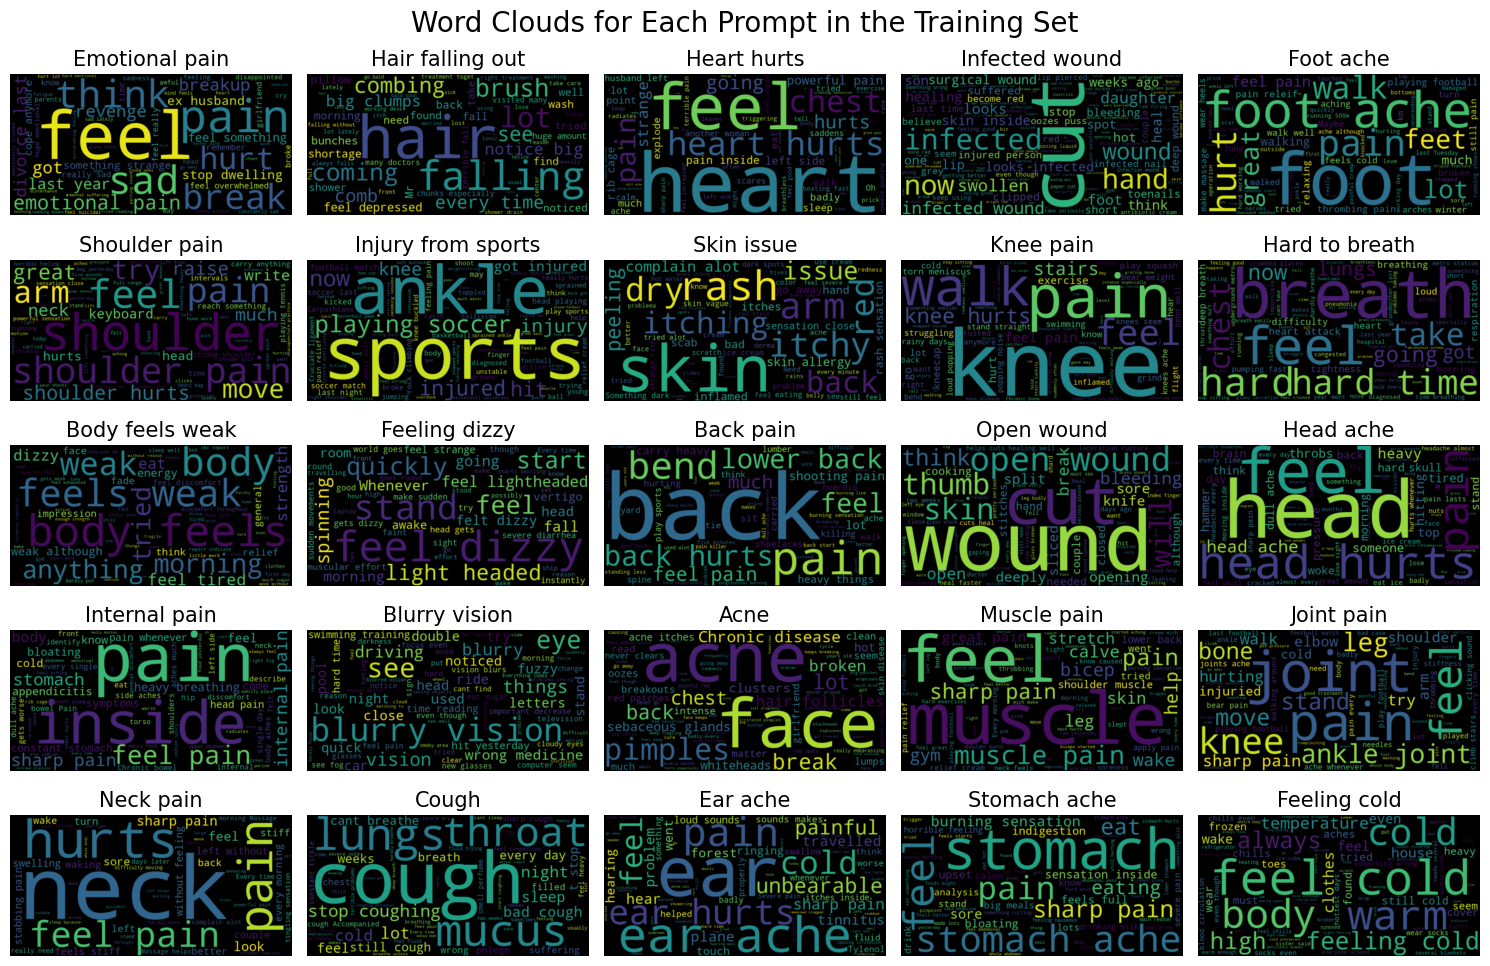

In [10]:
# Combine all phrases from the training set
all_phrases = ' '.join(train_df.phrase)

# Get unique prompts in the training set
unique_prompts = train_df.prompt.unique()

# Calculate the number of rows and columns for the subplot grid
num_prompts = len(unique_prompts)
cols = ceil(sqrt(num_prompts))
rows = ceil(num_prompts / cols)

# Create a figure with subplots
fig, axs = plt.subplots(rows, cols, figsize=(15, 10))

# Generate and display word clouds for each unique prompt
for ax, prompt in zip(axs.flatten(), unique_prompts):
    prompt_phrases = ' '.join(train_df[train_df.prompt == prompt].phrase)
    wordcloud = WordCloud(width=800, height=400).generate(prompt_phrases)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(prompt, fontsize=15)

# Remove empty subplots if there are more than needed
for ax in axs.flatten()[num_prompts:]:
    fig.delaxes(ax)

# Adjust layout for better visualization
fig.suptitle('Word Clouds for Each Prompt in the Training Set', fontsize=20)
plt.tight_layout()
plt.show()

## 1. Audio classification

#### 1.1 Train models

> See [part1.ipynb](./part1.ipynb) to know more about this part.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda
Waveforms already exist


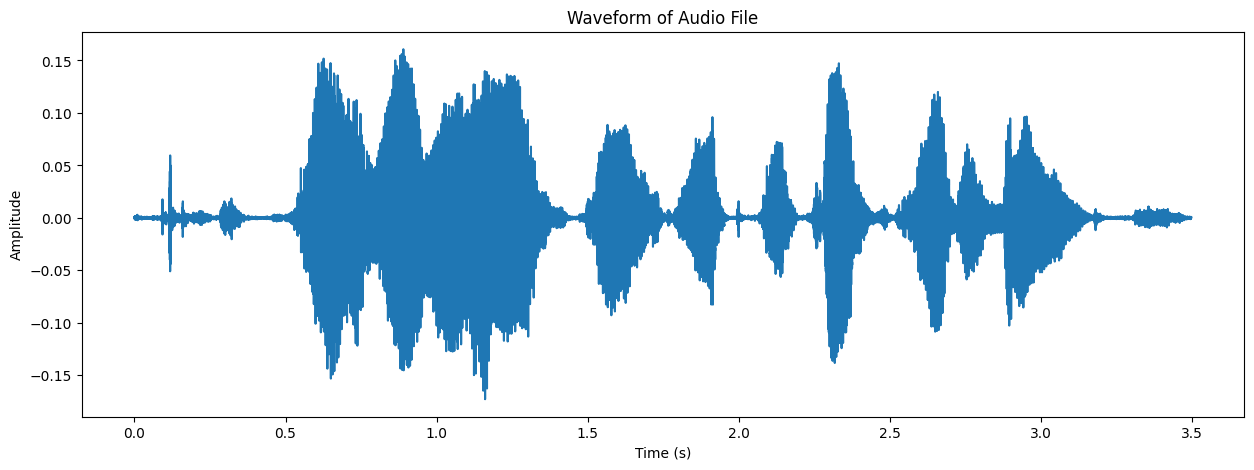

100%|██████████| 381/381 [00:00<00:00, 482.92it/s]


Train embeddings shape:  torch.Size([5895, 295730]) Train labels shape:  torch.Size([5895])
Valid embeddings shape:  torch.Size([385, 295730]) Valid labels shape:  torch.Size([385])
Test embeddings shape:  torch.Size([381, 295730]) Test labels shape:  torch.Size([381])
Loaded classifier from disk
Test accuracy: 4.46%


Some weights of the model checkpoint at superb/wav2vec2-base-superb-ks were not used when initializing Wav2Vec2ForSequenceClassification: ['wav2vec2.encoder.pos_conv_embed.conv.weight_v', 'wav2vec2.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at superb/wav2vec2-base-superb-ks and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.encoder.pos_conv_em

Loaded model from disk
Test accuracy: 87.66%


Some weights of the model checkpoint at superb/hubert-base-superb-ks were not used when initializing HubertForSequenceClassification: ['hubert.encoder.pos_conv_embed.conv.weight_g', 'hubert.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-base-superb-ks and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametriza

Loaded model from disk
Test accuracy: 92.65%


In [11]:
# Uncomment to run the code for part 1
%run ./part1.ipynb

#### 1.2 Visualize Results

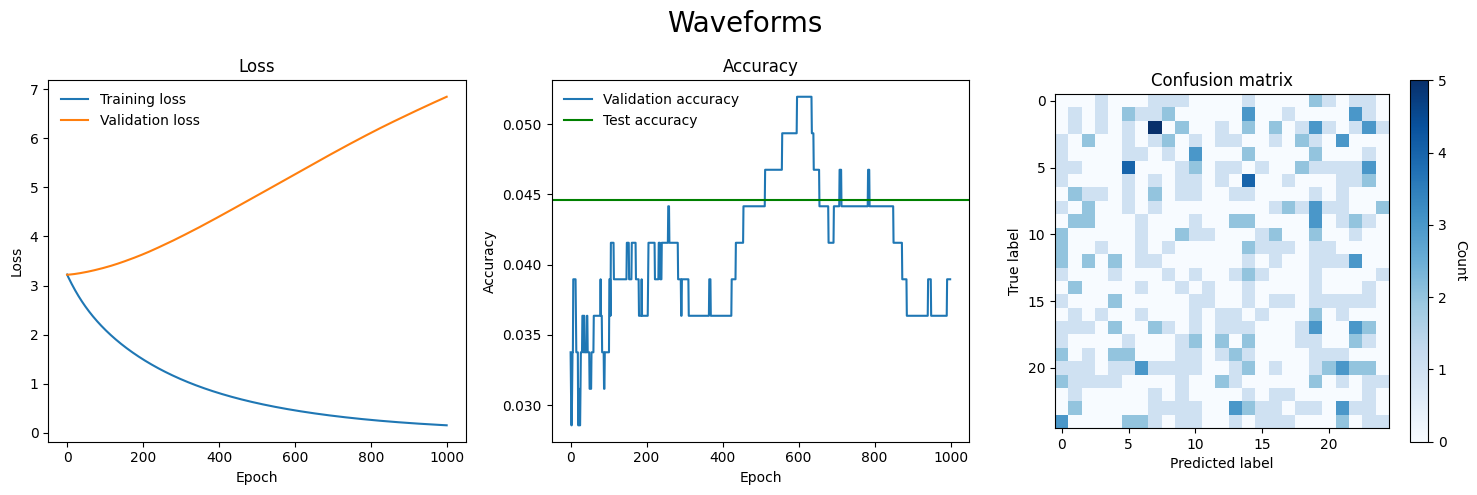

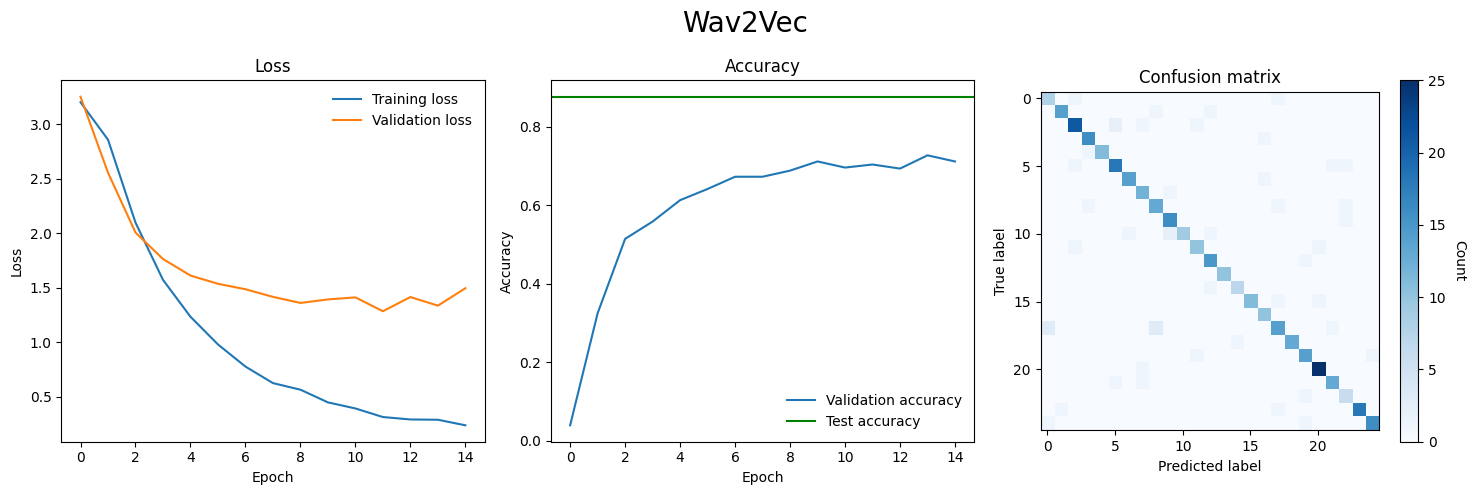

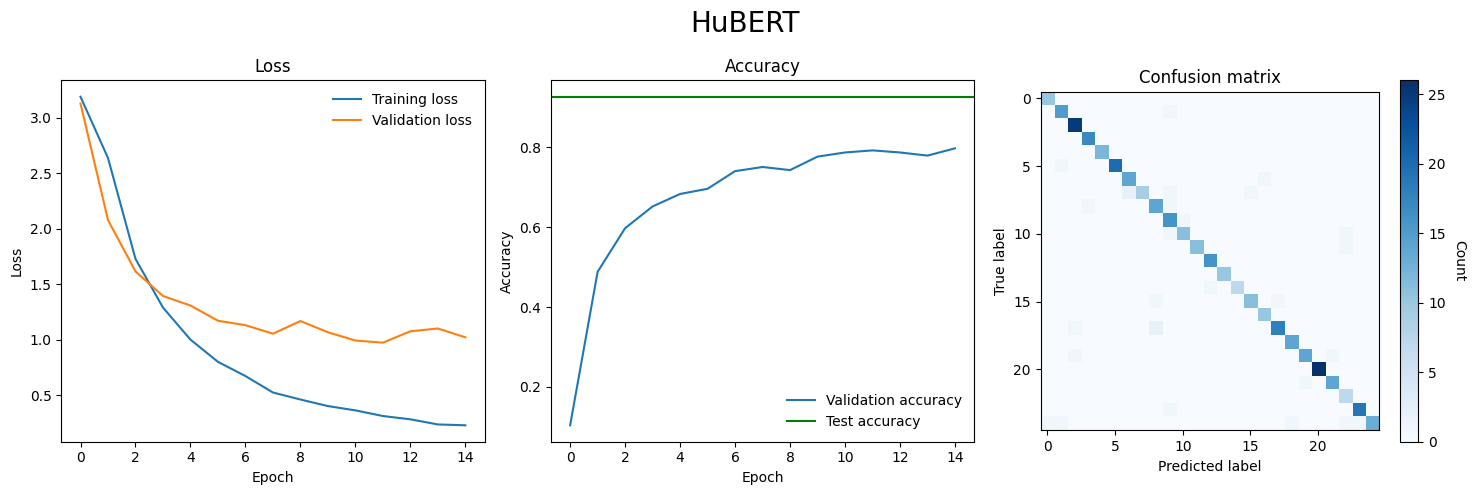

In [12]:
RESULTS_WAVEFORMS = RESULTS_DIR + "waveforms/"
RESULTS_WAV2VEC = RESULTS_DIR + "wav2vec/"
RESULTS_HUBERT = RESULTS_DIR + "hubert/"

# Plot the performance of each model
plot_model_performance(RESULTS_WAVEFORMS, "Waveforms")
plot_model_performance(RESULTS_WAV2VEC, "Wav2Vec")
plot_model_performance(RESULTS_HUBERT, "HuBERT")

#### 1.3 Experiment by yourself

In [13]:
# Record a sample audio file
speech_to_wav(DATA_DIR + "sample.wav")

In [14]:
# Initialize the tokenizer and model and load the weights
feature_extractor = AutoFeatureExtractor.from_pretrained("superb/hubert-base-superb-ks")
model = HubertForSequenceClassification.from_pretrained("superb/hubert-base-superb-ks", num_labels=len(record_df.prompt.unique()), ignore_mismatched_sizes=True).to(device)
model.load_state_dict(torch.load(RESULTS_DIR + "hubert.pt"), strict=False)

Some weights of the model checkpoint at superb/hubert-base-superb-ks were not used when initializing HubertForSequenceClassification: ['hubert.encoder.pos_conv_embed.conv.weight_g', 'hubert.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-base-superb-ks and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametriza

<All keys matched successfully>

In [15]:
# Predict the prompt for the sample audio file
y, sr = librosa.load(DATA_DIR + "sample.wav", sr=16000)
inputs = feature_extractor(y, sampling_rate=sr, return_tensors="pt")
logits = model(inputs.input_values.to(device), attention_mask=inputs.attention_mask.to(device)).logits
preds = torch.argmax(logits, dim=1)

print("Predicted prompt: ", id_to_prompt[preds.item()])

Predicted prompt:  Foot ache


## 2. Text classification

#### 2.1 Train models

> See [part2.ipynb](./part2.ipynb) to know more about this part.

In [16]:
# Uncomment to run the code for part 2
%run ./part2.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda
Embeddings already exist


100%|██████████| 381/381 [00:00<00:00, 1583.36it/s]


Train embeddings shape:  torch.Size([5895, 1024]) Train labels shape:  torch.Size([5895])
Valid embeddings shape:  torch.Size([385, 1024]) Valid labels shape:  torch.Size([385])
Test embeddings shape:  torch.Size([381, 1024]) Test labels shape:  torch.Size([381])
Loaded classifier from disk
Test accuracy: 99.74%


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded large bert from disk
Test accuracy: 99.74%


#### 2.2 Visualize Results

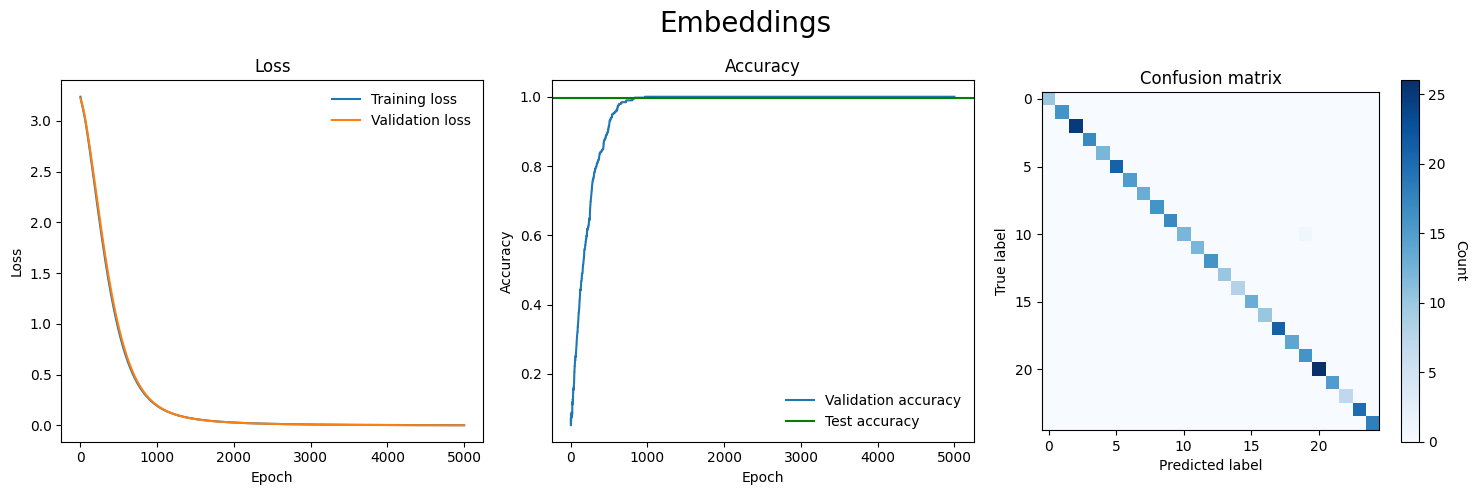

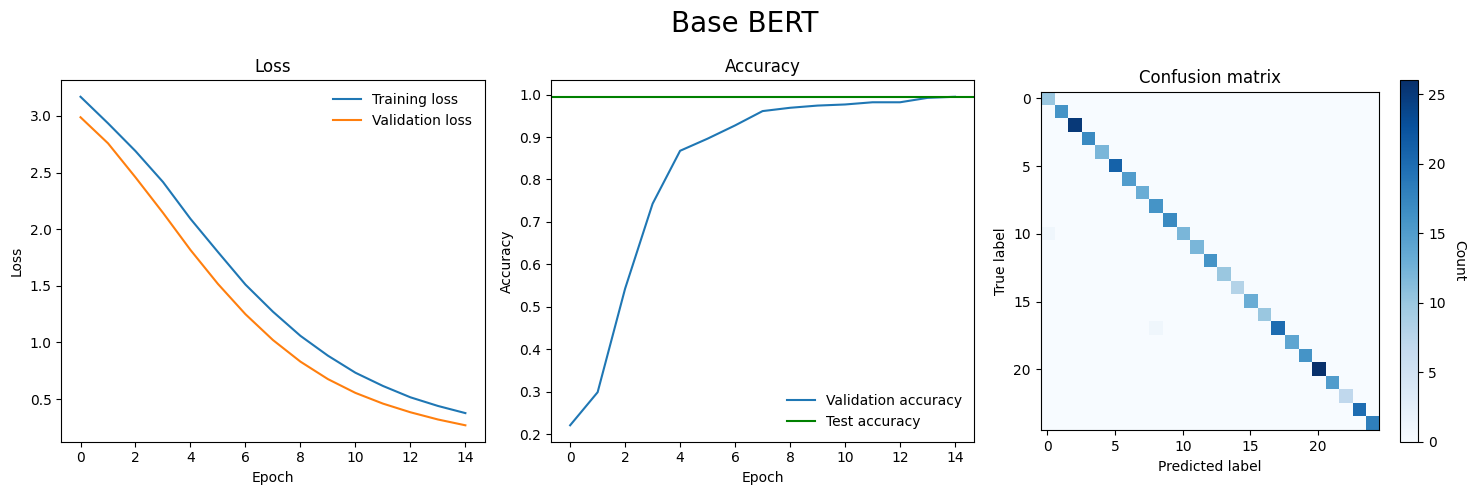

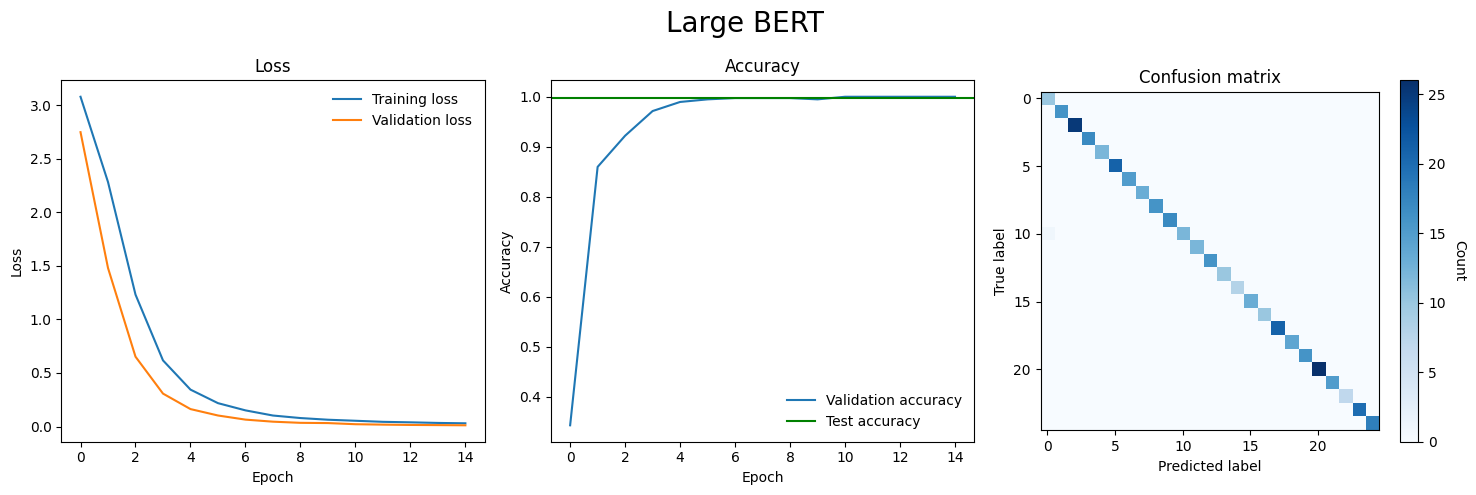

In [17]:
RESULTS_EMBEDDINGS = RESULTS_DIR + "embeddings/"
RESULTS_BASE_BERT = RESULTS_DIR + "base_bert/"
RESULTS_LARGE_BERT = RESULTS_DIR + "large_bert/"


# Plot the performance of each model
plot_model_performance(RESULTS_EMBEDDINGS, "Embeddings")
plot_model_performance(RESULTS_BASE_BERT, "Base BERT")
plot_model_performance(RESULTS_LARGE_BERT, "Large BERT")

#### 2.3 Experiment by yourself

In [18]:
# Write a sample phrase
phrase = "My foot hurts"

In [19]:
# Initialize the tokenizer and model and load the weights
tokenizer = BertTokenizer.from_pretrained("bert-large-uncased")
model = BertForSequenceClassification.from_pretrained("bert-large-uncased", num_labels=len(record_df.prompt.unique())).to(device)
model.load_state_dict(torch.load(RESULTS_DIR + "large_bert.pt"), strict=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [20]:
# Predict the prompt for the sample phrase
inputs = tokenizer(phrase, return_tensors="pt")
logits = model(inputs.input_ids.to(device), attention_mask=inputs.attention_mask.to(device)).logits
preds = torch.argmax(logits, dim=1)

print("Predicted prompt: ", id_to_prompt[preds.item()])

Predicted prompt:  Foot ache


## 3. Audio to text classification

#### 3.1 Train models

> See [part3.ipynb](./part3.ipynb) to know more about this part.

In [21]:
# Uncomment to run the code for part 3
%run ./part3.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda


Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_v', 'wav2vec2.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0']
You sho

Test accuracy: 13.39%


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test accuracy: 65.09%


#### 3.2 Visualize Results

Speech-to-Text Accuracy (word by word): 13.39%


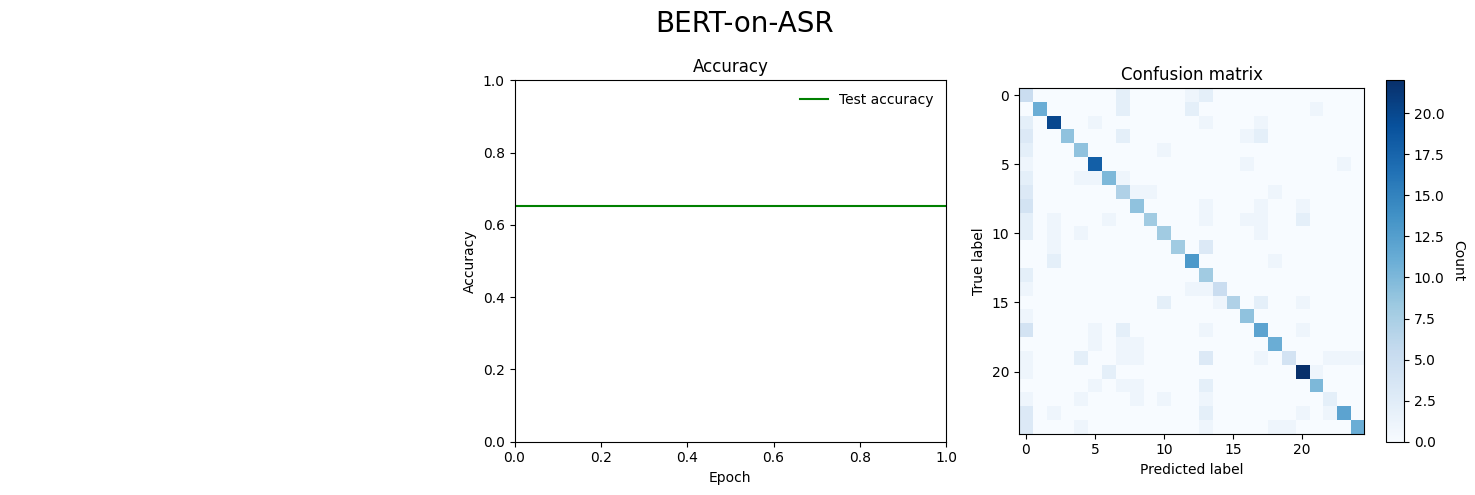

In [22]:
RESULTS_SPEECH_TO_TEXT = RESULTS_DIR + "speech_to_text/"
RESULTS_BERT_ON_ASR = RESULTS_DIR + "bert_on_asr/"

print(f'Speech-to-Text Accuracy (word by word): {np.load(RESULTS_SPEECH_TO_TEXT + "test_acc.npy") * 100:.2f}%')

# Plot the performance of each model
plot_model_performance(RESULTS_BERT_ON_ASR, "BERT-on-ASR")

#### 3.3 Experiment by yourself

In [23]:
# Record a sample audio and convert it to text
phrase = speech_to_text()
print("Phrase: ", phrase)

Recording...
Phrase:  my foot hurts


In [25]:
# Initialize the tokenizer and model and load the weights
tokenizer = BertTokenizer.from_pretrained("bert-large-uncased")
model = BertForSequenceClassification.from_pretrained("bert-large-uncased", num_labels=len(record_df.prompt.unique())).to(device)
model.load_state_dict(torch.load(RESULTS_DIR + "large_bert.pt"), strict=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [26]:
# Predict the prompt for the sample phrase
inputs = tokenizer(phrase, return_tensors="pt")
logits = model(inputs.input_ids.to(device), attention_mask=inputs.attention_mask.to(device)).logits
preds = torch.argmax(logits, dim=1)

print("Predicted prompt: ", id_to_prompt[preds.item()])

Predicted prompt:  Foot ache
